# 第三組：對PTT和Dcard上的爆紅韓劇《魷魚遊戲》進行情緒分析

- 組員: M094030040 孫亦農、M094810008 黃子源、M104020017 林妤姍、M104020021 劉雨瑈、M104020037 林元雅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/讀書會/Assignment_1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

fm.fontManager.ttflist += fm.createFontList([r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf'])

# 後續在相關函式中增加 plt.rcParams["font.family"] = "Taipei Sans TC Beta" 即可 # 將字體變成台北思源黑體


## **Outline**

+ **1. 資料前處理**
    + 1.1 基本資料介紹
    + 1.2 資料清理
    + 1.3 文章斷詞
+ **2. lexicon-base 情緒分析**
    + 2.1 準備LIWC、NTUSD情緒字典
    + 2.2 情緒字典與斷詞結果進行合併
    + 2.3 正負向情緒分數聲量折線圖
    + 2.4 正負向情緒分數比例折線圖
    + 2.5 文字雲
    + 2.6 情緒代表字
    + 2.7 歸類正負面文章
    + 2.8 情緒關鍵字
    + 2.9 與Dcard文集比較
+ **3.《魷魚遊戲》第一集 情緒分析**
    + 3.1 第一集文章&評論資料清理
    + 3.2 NTUSD 情緒分析
    + 3.3 文字雲
+ **4.《魷魚遊戲》演員/角色 討論聲量比較**
+ **5.《魷魚遊戲》遊戲項目 討論聲量比較**



## 1. 資料前處理

### 1.1 基本資料介紹
- 資料來源: 
  + 文字平台收集PTT Gossip版 2021-09-17 ~ 2021-10-25 所有文章&評論
  + 文字平台收集PTT KoreaDrama版 2021-09-17 ~ 2021-10-25 所有文章&評論
  + 撰寫爬蟲收集Dard《魷魚遊戲》2021-09-17 ~ 2021-10-25 所有文章
- 資料集： 
  + `raw_data/PTT_KoreaDrama_articleMetaData.csv`
  + `raw_data/PTT_KoreaDrama_articleReviews.csv`
  + `raw_data/PTT_Gossip_articleMetaData.csv`
  + `raw_data/PTT_Gossip_articleReviews.csv`
  + `raw_data/Dcard_Squid_articleMetaData.csv`

- 關鍵字：魷魚遊戲
- 資料時間：2021-09-17 ~ 2021-10-25 

主要分析ptt和Dcard上網友的相關討論情形。本次針對以下方向分析：
1. 《魷魚遊戲》在哪一天討論度最高? 為什麼?
2. 網友對於《魷魚遊戲》抱持正面或負面看法
3. 劇中討論聲量最高的演員/角色、遊戲、集數?

In [ ]:
#匯入PTT韓劇版資料
KD_MetaData = pd.read_csv('./raw_data/PTT_KoreaDrama_articleMetaData.csv', encoding='UTF-8')
KD_Reviews = pd.read_csv('./raw_data/PTT_KoreaDrama_articleReviews.csv', encoding='UTF-8')

In [ ]:
print(f"PTT韓劇版共有 {KD_MetaData.shape[0]} 篇文章") #(row,column)
KD_MetaData.head(3)

PTT韓劇版共有 131 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,劇名\n魷魚遊戲\n節目網址\nhttps://www.netflix.com/title/...
1,[心得]魷魚遊戲（雷）,2021/09/17,17:19:44,https://www.ptt.cc/bbs/KoreaDrama/M.1631899188...,woodgatel,KoreaDrama,402,146,2,今天休假\n花了一整個下午把這部新上架的網劇看完\n想說寫一篇心得文來討論劇情\n\n\n\...
2,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,有關這部魷魚遊戲，個人覺得值得推薦\n\n看人性面對金錢誘惑時的貪婪\n\n看人性在性命攸關...


In [ ]:
print(f"PTT韓劇版共有 {KD_Reviews.shape[0]} 個留言")
KD_Reviews.head(3)

PTT韓劇版共有 6894 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,yutan0802,推,2021-09-17 16:18:00,:孔劉既然有出現XDD
1,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,yutan0802,→,2021-09-17 16:18:00,:*竟
2,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,dora1023,推,2021-09-17 16:22:00,:推孔劉有說會客串只是角色保密


In [ ]:
#匯入PTT八卦版資料
G_MetaData = pd.read_csv('./raw_data/PTT_Gossip_articleMetaData.csv', encoding='UTF-8')
G_Reviews = pd.read_csv('./raw_data/PTT_Gossip_articleReviews.csv', encoding='UTF-8')

In [ ]:
print(f"PTT八卦版共有 {G_MetaData.shape[0]} 篇文章") #(row,column)
G_MetaData.head(3)

PTT八卦版共有 979 篇文章


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝\n\n其餘全部死光\n\n爽拿所有獎金\n\n然後一開始有腦癌的老頭居然...
1,[問卦]韓國為什麼拍得出魷魚遊戲？,2021/09/18,17:27:22,https://www.ptt.cc/bbs/Gossiping/M.1631986044....,leonemamo,Gossiping,90,33,12,最近看魷魚遊戲\n\n日本的大逃殺、好萊塢的飢餓遊戲直接被海放\n\n為什麼韓國拍得出這麼獵...
2,Re:[問卦]韓國為什麼拍得出魷魚遊戲？（有雷看完再來）,2021/09/18,18:15:37,https://www.ptt.cc/bbs/Gossiping/M.1631988940....,henryhuang17,Gossiping,13,2,0,魷魚遊戲我覺得算前面還好\n後面有比較好看\n\n-防雷-\n\n\n\n\n\n\n\n\...


In [ ]:
print(f"PTT八卦版共有 {G_Reviews.shape[0]} 個留言")
G_Reviews.head(3)

PTT八卦版共有 39752 個留言


,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,tryagain24,噓,2021-09-17 21:14:00,:...?
1,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,aclock,→,2021-09-17 21:14:00,:有看過奪魂鋸一你就不意外了
2,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,halfmoon6,推,2021-09-17 21:15:00,:雷三小雞排


In [ ]:
#分別合併PTT韓劇版和八卦版的文章&評論
MetaData = KD_MetaData.append(G_MetaData,ignore_index=True)
MetaData.iloc[KD_MetaData.shape[0]-1:KD_MetaData.shape[0]+2,:]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
130,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,11,8,1,https://reurl.cc/73Kex5\n刊登在方格子的文章(含圖說)\n\n\n《...
131,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,最後就剩李政宰獲勝\n\n其餘全部死光\n\n爽拿所有獎金\n\n然後一開始有腦癌的老頭居然...
132,[問卦]韓國為什麼拍得出魷魚遊戲？,2021/09/18,17:27:22,https://www.ptt.cc/bbs/Gossiping/M.1631986044....,leonemamo,Gossiping,90,33,12,最近看魷魚遊戲\n\n日本的大逃殺、好萊塢的飢餓遊戲直接被海放\n\n為什麼韓國拍得出這麼獵...


In [ ]:
Reviews = KD_Reviews.append(G_Reviews,ignore_index=True)
Reviews.iloc[KD_Reviews.shape[0]-1:KD_Reviews.shape[0]+3,:]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
6893,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,bbob,推,2021-10-25 23:36:00,:一樓可以桶了啦
6894,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,tryagain24,噓,2021-09-17 21:14:00,:...?
6895,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,aclock,→,2021-09-17 21:14:00,:有看過奪魂鋸一你就不意外了
6896,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,halfmoon6,推,2021-09-17 21:15:00,:雷三小雞排


In [ ]:
print(f"PTT韓劇版+八卦版共有 {MetaData.shape[0]} 篇文章") #(row,column)
print(f"PTT韓劇版+八卦版共有 {Reviews.shape[0]} 個評論") #(row,column)

PTT韓劇版+八卦版共有 1110 篇文章
PTT韓劇版+八卦版共有 46646 個評論


In [ ]:
# 再篩一次文章
keywords = ['魷魚','魷魚遊戲']
toMatch = '|'.join(keywords)
toMatch

'魷魚|魷魚遊戲'

In [ ]:
# 篩出包含「魷魚」或「魷魚遊戲」字詞的文章
MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1109, 10)


In [ ]:
# 為進行後續分析，篩選出包含「第一集」相關字詞的文章

Ep_keywords = ['第一集','第1集','EP1','ep1']  #最多
#這樣篩有(38,10)
#keywords = ['第二集','第2集','EP2','ep2']
#這樣篩有(2,10)
#keywords = ['第三集','第3集','EP3','ep3']
#這樣篩有(4,10)
#keywords = ['第四集','第4集','EP4','ep4']
#這樣篩有(3,10)
#keywords = ['第五集','第5集','EP5','ep5']
#這樣篩有(0,10)
#keywords = ['第六集','第6集','EP6','ep6']
#這樣篩有(5,10)
#keywords = ['第七集','第7集','EP7','ep7']
#這樣篩有(4,10)
#keywords = ['第八集','第8集','EP8','ep8']
#這樣篩有(3,10)
#keywords = ['第九集','第9集','EP9','ep9']
#這樣篩有(2,10)

Ep_toMatch = '|'.join(Ep_keywords)

Ep_MetaData = MetaData.loc[MetaData['sentence'].str.contains(Ep_toMatch) | MetaData['artTitle'].str.contains(Ep_toMatch), :].copy()
Ep_MetaData.reset_index(inplace=True, drop=True) #重設index
print(Ep_MetaData.shape)

(38, 10)


In [ ]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [ ]:
# 檢查是否成功合併韓劇版和八卦版的評論資料
print(Reviews.shape)
Reviews.iloc[KD_Reviews.shape[0]:KD_Reviews.shape[0]+5,:]

(46654, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
6894,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,11,8,1,:回一樓：很重要謝謝
6895,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,11,8,1,:一樓在派什麼，不懂尊重的傢伙
6896,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,11,8,1,:一樓可以桶了啦
6897,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,:...?
6898,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,:有看過奪魂鋸一你就不意外了


### 1.2 資料清理  
- 去除NA值
- 去除網址、換行
- 去除非中文、英文字母大小寫E和P、數字以外的符號
  + 需要篩選出集數的相關詞「EP」，所以保留英文字母E和P
  + 《魷魚遊戲》劇中角色皆有代表的編號，例如 001、456號，因此保留數字



#### 文章的資料清理

In [ ]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x)) #去除網址
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', '', x)) #去除換行

In [ ]:
#正規式: ^:非 / \u4e00-\u9fa5:所有中文的編碼範圍
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa50-9EPep]+', '', x)) #去除非中文、英文字母大小寫E和P、數字以外的符號

In [ ]:
MetaData.iloc[KD_MetaData.shape[0]:KD_MetaData.shape[0]+3,:]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
131,[問卦]韓國為什麼拍得出魷魚遊戲？,2021/09/18,17:27:22,https://www.ptt.cc/bbs/Gossiping/M.1631986044....,leonemamo,Gossiping,90,33,12,最近看魷魚遊戲日本的大逃殺好萊塢的飢餓遊戲直接被海放為什麼韓國拍得出這麼獵奇刺激的電視劇有魷...
132,Re:[問卦]韓國為什麼拍得出魷魚遊戲？（有雷看完再來）,2021/09/18,18:15:37,https://www.ptt.cc/bbs/Gossiping/M.1631988940....,henryhuang17,Gossiping,13,2,0,魷魚遊戲我覺得算前面還好後面有比較好看防雷但為什麼最後第六天要決勝的比賽是用打架的方式啊魷魚...
133,[問卦]台灣找個離島辦魷魚遊戲會有人參加嗎,2021/09/18,18:59:16,https://www.ptt.cc/bbs/Gossiping/M.1631991558....,BaGaJohn5566,Gossiping,14,2,6,如果台灣找個澎湖離島蘭嶼綠島來辦魷魚遊戲玩一下鬥片鬼抓人之類的小孩遊戲開放想賺錢的人參加參加...


#### 評論的資料清理

In [ ]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [ ]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('(http|https)://.*', '', x)) #去除網址
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('\n', '', x)) #去除換行
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa50-9EPep]+', '', x)) #去除非中文、英文字母大小寫E和P、數字以外的符號
Reviews.iloc[KD_Reviews.shape[0]-1:KD_Reviews.shape[0]+3,:]

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
6896,[心得]《魷魚遊戲》–我知道這是假的，但是…,2021/10/23,05:40:45,https://www.ptt.cc/bbs/KoreaDrama/M.1634967648...,plurrr,KoreaDrama,11,8,1,一樓可以桶了啦
6897,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,
6898,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,有看過奪魂鋸一你就不意外了
6899,[問卦]魷魚遊戲的老頭居然是主辦方之一?,2021/09/17,13:13:43,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,lovesaber,Gossiping,20,1,16,雷三小雞排


### 1.3 文章斷詞
- 中文文集我們使用`jieba`套件進行斷詞與移除停用字
- 另外也使用《魷魚遊戲》自定義詞典協助斷詞
  + 詞典內容包含: 遊戲項目(椪糖、玻璃橋)、角色、相同類型的戲劇(今際之國的闖關者)等

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增《魷魚遊戲》相關自定義字典
jieba.load_userdict('./dict/squid_dict.txt')

#新增stop words
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /content/drive/My Drive/讀書會/Assignment_1/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ua4bf7389cb4d2437960144cb753a4ac8.cache
Loading model cost 1.624 seconds.
Prefix dict has been built successfully.


In [ ]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [ ]:
MetaData['word'] = MetaData.sentence.apply(getToken)
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [ ]:
# 將word欄位展開
# 將list的每個元素轉換為一行，並複製索引值
MetaData_token = MetaData.explode('word') 
Reviews_token = Reviews.explode('word') 

In [ ]:
MetaData_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,劇名魷魚遊戲節目網址播出時間9月17日e獨家全球上線集數9集,劇名
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,劇名魷魚遊戲節目網址播出時間9月17日e獨家全球上線集數9集,魷魚遊戲
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,劇名魷魚遊戲節目網址播出時間9月17日e獨家全球上線集數9集,節目


In [ ]:
Reviews_token.head()

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,孔劉既然有出現,孔劉
1,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,竟,NaN
2,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,推孔劉有說會客串只是角色保密,孔劉
2,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,推孔劉有說會客串只是角色保密,客串
2,[情報]Netflix《魷魚遊戲》(全劇已上架),2021/09/17,08:10:35,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,yihsuan1122,KoreaDrama,249,134,5,推孔劉有說會客串只是角色保密,角色


In [ ]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

,artDate,artUrl,word
0,2021/09/17,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,劇名
0,2021/09/17,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,魷魚遊戲
0,2021/09/17,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,節目
0,2021/09/17,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,網址
0,2021/09/17,https://www.ptt.cc/bbs/KoreaDrama/M.1631866241...,播出


In [ ]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [ ]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head()

,artDate,word,size
45712,2021-10-03,台灣,345
50650,2021-10-03,遊戲,333
41914,2021-10-02,塔綠班,324
31039,2021-09-28,遊戲,301
36502,2021-09-30,日本,289


In [ ]:
#計算整個資料期間，不同字的詞頻
word_all = data.groupby(['word'],as_index=False).size()
word_all.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_all.head()

,word,size
31733,遊戲,3594
35494,魷魚遊戲,2236
7154,台灣,2206
24123,真的,2119
17306,日本,1847


## 2. lexicon-base 情緒分析

### 2.1 準備LIWC字典   
- 分為正向情緒與負向情緒

In [ ]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

In [ ]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc.head()

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative


### 2.1(續) 準備NTUSD字典
- 分為正向情緒與負向情緒

In [ ]:
filepath = ['negative','positive']
d_ntusd = []
for file in filepath:
    filename = f"./dict/ntusd-{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
      for line in f:
        d_ntusd.append([line.splitlines(),file])

In [ ]:
df_ntusd = pd.DataFrame(d_ntusd,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_ntusd.head()

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative


### 2.2 情緒字典與斷詞結果進行合併

##### 每日韓劇版+八卦版的發文數量

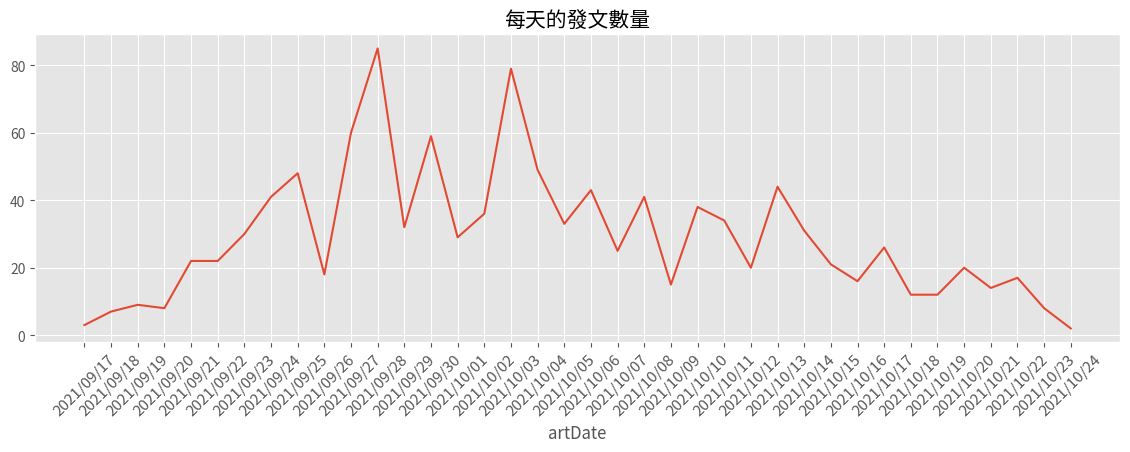

In [ ]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(14,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體

plt.title('每天的發文數量', fontsize=15)
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

- 討論度最高是在9月27日到10月2日之間，推測上線後一個禮拜，隨著觀看人數增加，討論度也隨之提高。
- 10月2日以後討論聲量逐漸下降，《魷魚遊戲》漸漸退燒。

##### 合併LIWC、NTUSD 情緒字典與斷詞結果

In [ ]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

,artDate,sentiments,size
0,2021-09-17,negative,151
1,2021-09-17,positive,184
2,2021-09-18,negative,77
3,2021-09-18,positive,120
4,2021-09-19,negative,81


In [ ]:
#文章和與NTUSD情緒字典做合併
data_ntusd = pd.merge(data, df_ntusd, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
ntusd_sentiment_count = data_ntusd.groupby(['artDate','sentiments'],as_index=False).size()
ntusd_sentiment_count.head()

,artDate,sentiments,size
0,2021-09-17,negative,426
1,2021-09-17,positive,238
2,2021-09-18,negative,186
3,2021-09-18,positive,104
4,2021-09-19,negative,251


- 個別將文章和LIWC、NTUSD情緒字典合併後，可發現NTUSD抓出的正負面情緒字詞較多
- 因此，以下將使用NTUSD字典與文章合併後的結果來進行情緒分析

### 2.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

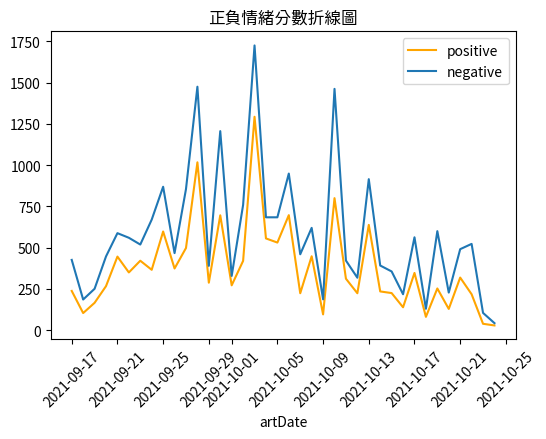

In [ ]:
p = ntusd_sentiment_count[ntusd_sentiment_count['sentiments']=='positive']
n = ntusd_sentiment_count[ntusd_sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

畫出每天的情緒總分數，可以看到負面情緒一直都較正面情緒多。

### 2.4 正負向情緒分數比例折線圖

In [ ]:
sentiment_count_r = ntusd_sentiment_count.assign(ratio = ntusd_sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

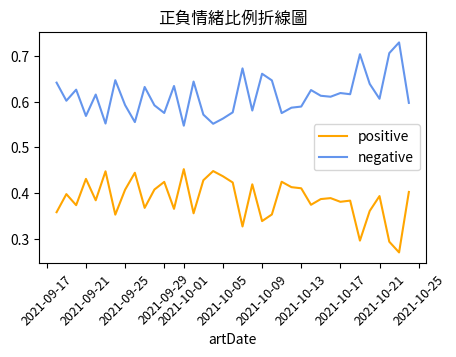

In [ ]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/9/17']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

#print(p.head())
#print(n.head())

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative',color="cornflowerblue")
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
#plt.axvline(x=datetime.strptime('2021-10-03', "%Y-%m-%d"), color="tomato", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-05', "%Y-%m-%d"), color="tomato", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-17', "%Y-%m-%d"), color="salmon", ls="-")
#plt.axvline(x=datetime.strptime('2021-10-20', "%Y-%m-%d"), color="salmon", ls="-")
plt.xlabel('artDate')
plt.show()

透過上圖，可以發現主要也都是負面情緒比例較高

### 2.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [ ]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

#### 2021-09-17 文字雲
《魷魚遊戲》於Netflix上檔的時間為9月17日。

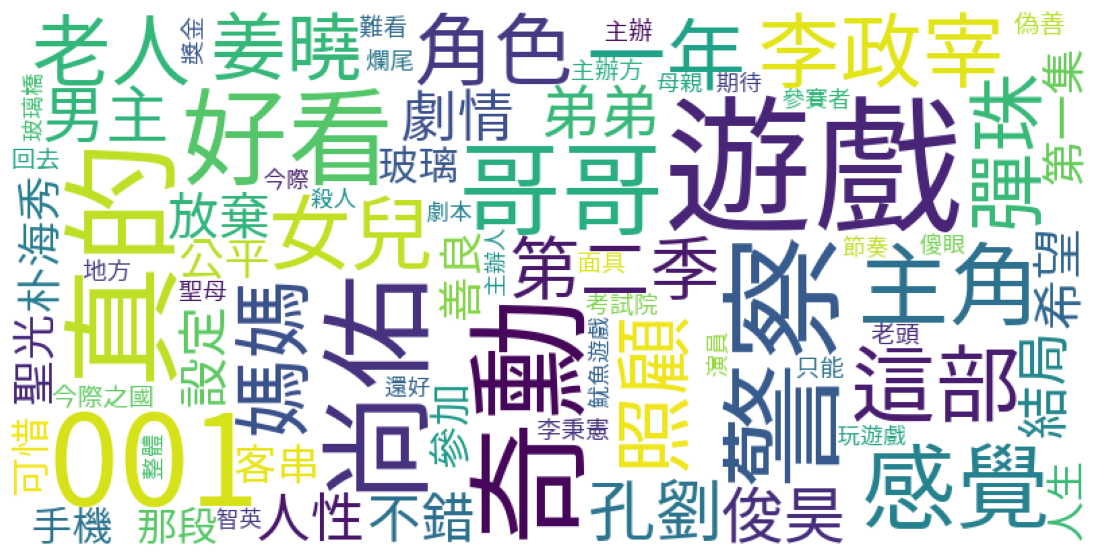

In [ ]:
dict_0917 = Wc_dict(word_count,"2021-09-17",450,5)

font = r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0917)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

- 畫出9月17日播出當天的文字雲，可以發現「001」、「奇勳」、「尚佑」、「警察」等第一集出場的主要角色的提及頻率較高
- 也可發現「爛尾」、「彈珠」、「玻璃橋」、「李秉憲」等後期才會出現的劇情和角色，也在文字雲中出現，顯示許多網友熬夜追劇。
- 「今際之國」也在第一天被提及，推測此劇讓很多網友聯想到日劇《今際之國的闖關者》

#### 整個資料期間的文字雲
觀察 2021-09-17 ~ 2021-10-25 整個資料期間的文字雲

In [ ]:
def Wc_dict2(df, countB, countS):
    wc_df2 = (df.query('size < @countB')# 篩選最大數量
           .query('size > @countS')# 篩選最小數量
           .sort_values('size', ascending=False))
    wc_dict2 = dict(zip(wc_df2['word'], wc_df2['size'])) #建立成dictionary
    
    return wc_dict2

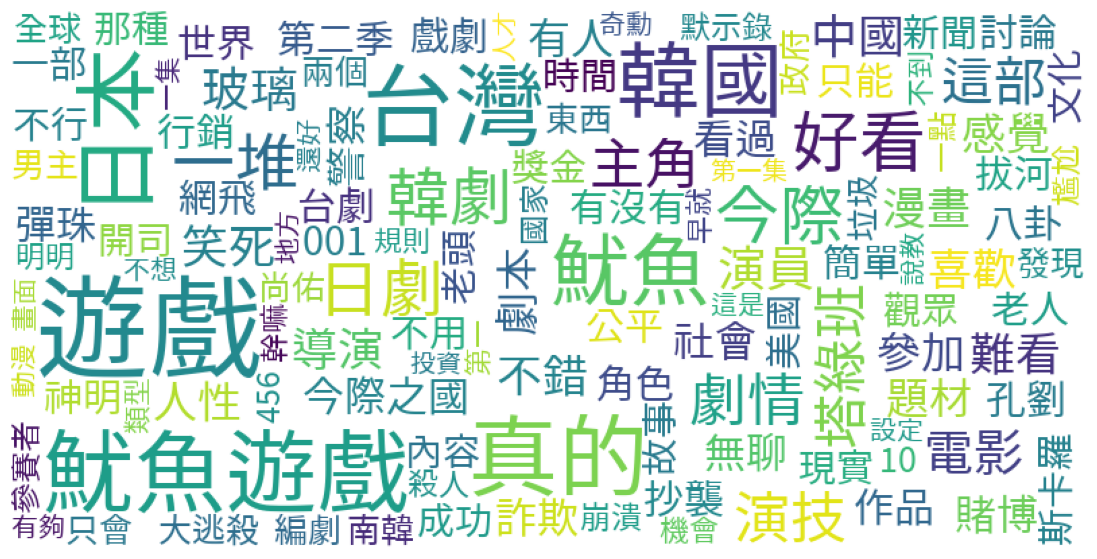

In [ ]:
dict_all_date = Wc_dict2(word_all,3600,180)

font = r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf' #中文字型路徑
wordcloud_all = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud_all.generate_from_frequencies(dict_all_date)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud_all)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

- 在整個期間的文字雲當中，可以看到「台灣」、「日本」、「韓國」、「中國」等國家，推測是有許多網友在討論台灣是否能拍出此類作品、以及和各國的拍片手法作比較。

### 2.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [ ]:
sentiment_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
374,難看,negative,904
72,喜歡,positive,864
238,無聊,negative,696
40,公平,positive,528
278,笑死,positive,490


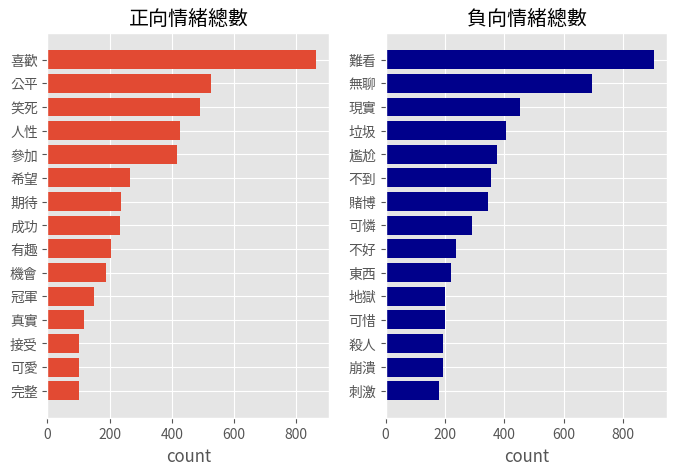

In [ ]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

- 正向情緒最高的「喜歡」和負面情緒最高的「難看」字詞總數旗鼓相當，顯示網友對於《魷魚遊戲》評價兩極
- 負面情緒字詞總數高於正面總數，推測是因為魷魚遊戲本身劇情描寫人性的險惡、也經常出現血腥暴力的畫面，所以在討論上較常使用「現實」、「賭博」、「可憐」、「殺人」等負面詞彙。

#### 2021-09-17 正負情緒代表字

In [ ]:
sentiment_date_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_0917 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-09-17"].sort_values(by=['size'], ascending=False)
sentiment_0917.head()

,artDate,word,sentiments,size
16,2021-09-17,希望,positive,18
6,2021-09-17,公平,positive,18
9,2021-09-17,可惜,negative,16
4,2021-09-17,偽善,negative,16
36,2021-09-17,難看,negative,14


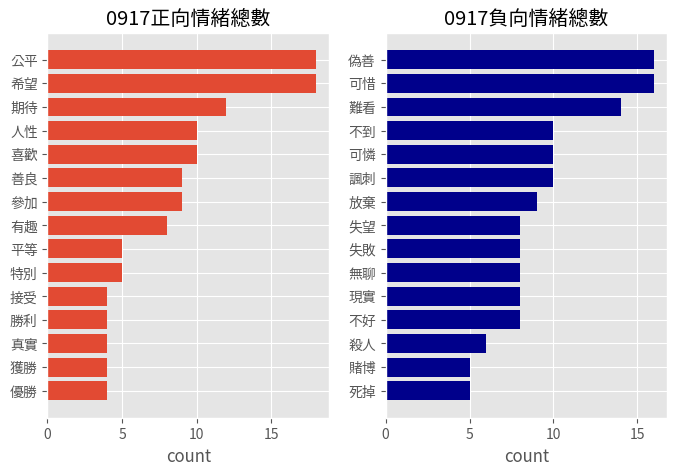

In [ ]:
p_sum = sentiment_0917[sentiment_0917["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_0917[sentiment_0917["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('0917正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('0917負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

#### 2021-10-17 正負情緒代表字

In [ ]:
#篩選日期
sentiment_1017 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-17"].sort_values(by=['size'], ascending=False)
sentiment_1017.head()

,artDate,word,sentiments,size
1495,2021-10-17,地獄,negative,48
1513,2021-10-17,現實,negative,36
1517,2021-10-17,驕傲,negative,26
1506,2021-10-17,樂趣,positive,24
1503,2021-10-17,有趣,positive,18


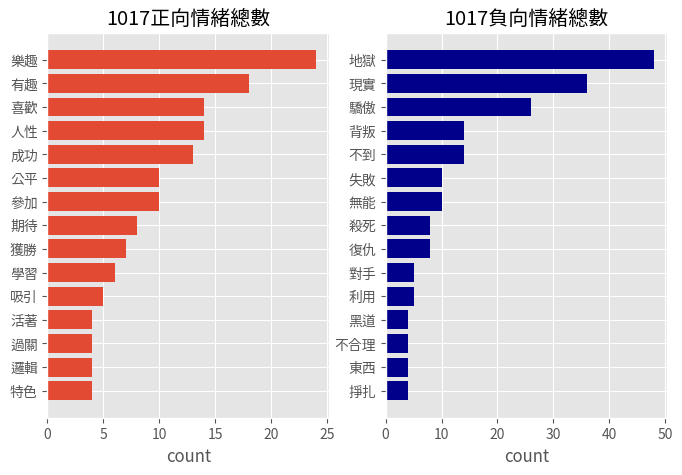

In [ ]:
p_sum = sentiment_1017[sentiment_1017["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_1017[sentiment_1017["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('1017正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('1017負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2.7 歸類正負面文章
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [ ]:
article_type = (data.merge(df_ntusd, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1631884426....,8,1
1,https://www.ptt.cc/bbs/Gossiping/M.1631986044....,31,14
2,https://www.ptt.cc/bbs/Gossiping/M.1631988940....,14,5
3,https://www.ptt.cc/bbs/Gossiping/M.1631991558....,9,8
4,https://www.ptt.cc/bbs/Gossiping/M.1632004934....,22,4


In [ ]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,824
1,positive,274


#### 正負情緒文章數量統計圖

In [ ]:
article_type_date = article_type.merge(MetaData.loc[:,["artUrl", "artDate"]], how = 'left', on = 'artUrl')
article_type_date = article_type_date.groupby(['artDate','type'], as_index=False).size()
#article_type_date

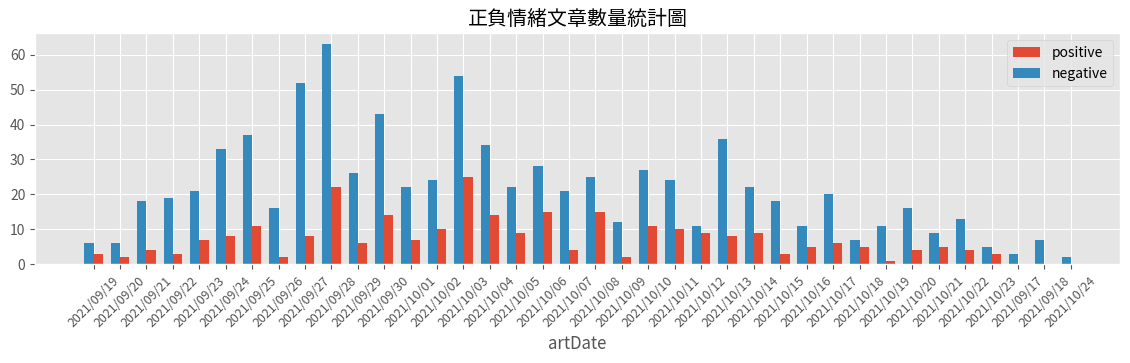

In [ ]:
ap = article_type_date[article_type_date["type"]=="positive"]
an = article_type_date[article_type_date["type"]=="negative"]

plt.figure(figsize=(14,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

### 2.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [ ]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

#### 情緒關鍵字:負面情緒文章

In [ ]:
negative_article = (negative_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

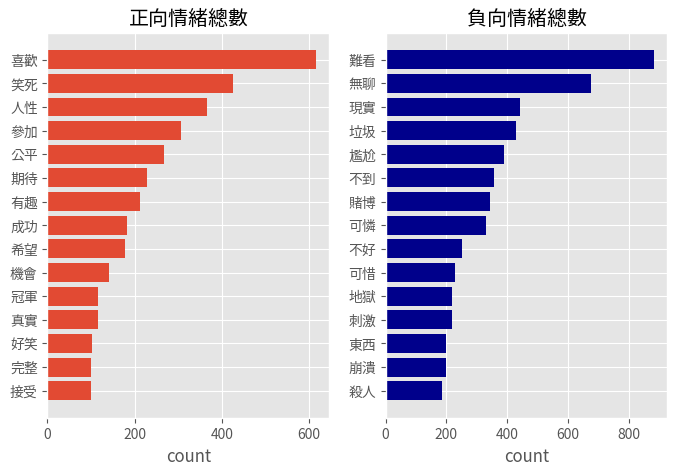

In [ ]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

#### 情緒關鍵字:正面情緒文章

In [ ]:
positive_article = (positive_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

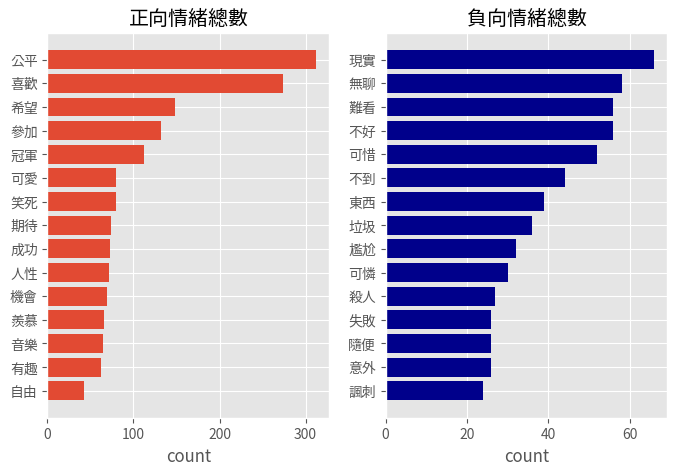

In [ ]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

從正負面情緒圖觀察發現，正面和負面的關鍵字沒有甚麼顯著的差異，負面情緒較高的文章比較常出現「難看」、「尷尬」、「現實」、「無聊」等討論相關劇情的字詞，比較著重在批評劇情；正面情緒較高的文章出現較多的「喜歡」、「笑死」、「公平」等字詞。

### 2.9 與Dcard文集比較
- 我們另外準備了Dcard的資料集，搜尋條件與PTT相同，想了解不同的社群媒體對於《魷魚遊戲》的情緒是否有差異。
- Dcard 爬蟲程式檔案: `Dcard_爬蟲.ipynb`


In [ ]:
Dcard = pd.read_csv('./raw_data/Dcard_Squid_articleMetaData.csv', encoding='UTF-8')

In [ ]:
print(f"共有 {Dcard.shape[0]} 篇Dcard文章")
Dcard.head()

共有 139 篇Dcard文章


,Unnamed: 0,id,title,content,excerpt,createdAt,likeCount,gender
0,0,237226391,有人注意到魷魚遊戲的政治隱喻嗎？,幾個貴賓觀賽者，冷眼旁觀著一群韓國人互相廝殺，六個貴賓中，五個白人是一夥，都用英語交流，以獅...,幾個貴賓觀賽者，冷眼旁觀著一群韓國人互相廝殺，六個貴賓中，五個白人是一夥，都用英語交流，以獅...,2021-10-14T17:03:01.325Z,3,M
1,1,237191982,從魷魚遊戲看中韓劇影響力落差,這劇可以討論的議題真多好多\nhttps://news.ltn.com.tw/news/wo...,這劇可以討論的議題真多好多,2021-10-10T06:06:17.696Z,11,F
2,2,237175517,彭博：魷魚遊戲提升南韓軟實力,最近多家外國媒體都在報導這部戲在全球大紅\nhttps://news.ltn.com.tw/...,最近多家外國媒體都在報導這部戲在全球大紅,2021-10-07T18:30:09.863Z,11,F
3,3,237155754,被魷魚遊戲邀請了,這是…魷魚遊戲遙控器！！！\n按下去就會通往123木頭人的場地嗎？\nhttps://i.i...,這是…魷魚遊戲遙控器！！！，按下去就會通往123木頭人的場地嗎？,2021-10-05T11:58:38.556Z,54,F
4,4,237139771,魷魚遊戲 微雷…嗎？\n反正有雷到沒看過別進來,就是我今天看到時候發現一件事\n先放防雷圖(✪ω✪) \nhttps://i.imgur.c...,就是我今天看到時候發現一件事，先放防雷圖（ω），就是第五集在警察翻名單的時候 他翻2015年...,2021-10-03T14:46:34.175Z,7,F


In [ ]:
Dcard['content'] = Dcard.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x)) # 對原始文章進行篩選，只留下中文字詞

In [ ]:
Dcard['word'] = Dcard.content.apply(getToken) # 使用先前定義的斷詞與清除停用字function

In [ ]:
DToken = Dcard.explode('word') # 展開斷詞結果

In [ ]:
DToken["source"] = "Dcard" # 設定新欄位source
DToken['createdAt'] = pd.to_datetime(DToken['createdAt'])
DToken['createdAt'] = DToken['createdAt'].apply(lambda x: x.strftime('%Y-%m-%d'))


PToken = data
PToken["source"] = "PTT" # 設定新欄位source

In [ ]:
Dcard_senti_sum = (DToken.filter(["createdAt","artUrl","word","source"])
                   .merge(df_ntusd, on='word')
                   .groupby(['createdAt', 'sentiments'], as_index=False)
                   .size()
                   .query('createdAt >= "2021-09-17" & createdAt <= "2021-10-25"'))

In [ ]:
PTT_senti_sum = (PToken
                 .merge(df_ntusd, on='word')
                 .groupby(['artDate', 'sentiments'], as_index=False)
                 .size()
                 .query('artDate >= "2021-09-17"'))

#### PTT、Dcard情緒分數比較

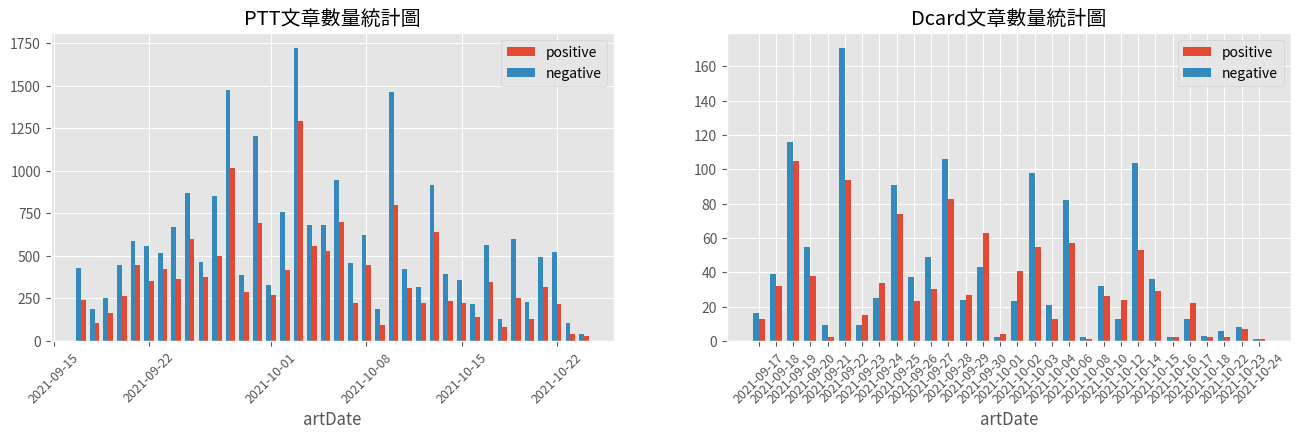

In [ ]:
PTT_ap = PTT_senti_sum[PTT_senti_sum["sentiments"]=="positive"]
PTT_an = PTT_senti_sum[PTT_senti_sum["sentiments"]=="negative"]
Dcard_ap = Dcard_senti_sum[Dcard_senti_sum["sentiments"]=="positive"]
Dcard_an = Dcard_senti_sum[Dcard_senti_sum["sentiments"]=="negative"]

plt.figure(figsize=(16,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('PTT文章數量統計圖')
plt.xlabel('artDate')
plt.bar(PTT_ap['artDate'],PTT_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(PTT_an['artDate'],PTT_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')


plt.subplot(122)
plt.title('Dcard文章數量統計圖')
plt.xlabel('artDate')
plt.bar(Dcard_ap['createdAt'],Dcard_ap['size'],align="edge",width=0.35,label="positive")
plt.bar(Dcard_an['createdAt'],Dcard_an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

PTT和Dcard的情緒分布直方圖，可以發現Dcard與PTT皆為負面情緒較多，話題討論度PTT較Dcard高出許多，且在PTT上的討論持續了比較久的時間。

## 3. 以集數來篩選文章&評論
*   經調查，發現第一集討論的最多，因此分析與第一集相關的內容

#### 3.1 第一集-資料清理

##### 第一集-文章的資料清理

In [ ]:
Ep_MetaData.head(3)

In [ ]:
Ep_MetaData['sentence'] = Ep_MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x)) #去除網址
Ep_MetaData['sentence'] = Ep_MetaData.sentence.apply(lambda x: re.sub('\n', '', x)) #去除換行
Ep_MetaData['sentence'] = Ep_MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa50-9EPep]+', '', x)) #去除非中文、英文字母大小寫E和P、數字以外的符號

In [ ]:
Ep_MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,有關這部魷魚遊戲個人覺得值得推薦看人性面對金錢誘惑時的貪婪看人性在性命攸關時的殘酷看陷入困境...,"[這部, 魷魚遊戲, 值得, 推薦, 人性, 面對, 金錢, 誘惑, 貪婪, 人性, 性命攸..."
1,[問題]網飛魷魚遊戲後面黑畫面,2021/09/18,17:10:34,https://www.ptt.cc/bbs/KoreaDrama/M.1631985036...,newsbow,KoreaDrama,47,31,0,如題看那麼久網飛第一次遇到這種情形我是用手機版看的第一集沒這問題第二集跟第三集到最後面五分多...,"[如題, 網飛, 第一次, 情形, 手機, 第一集, 第二集, 第三集, 五分, 多鐘, 變..."
2,[新聞]《魷魚遊戲》亮點盤點！大咖演員神秘登場,2021/09/22,09:54:27,https://www.ptt.cc/bbs/KoreaDrama/M.1632304469...,laiteng0105,KoreaDrama,36,28,1,雷雷雷雷雷魷魚遊戲亮點盤點孔劉神秘登場面具男是影帝李瑜美撞臉周冬雨魏河俊掀話題新聞連結文少女...,"[雷雷雷雷雷, 魷魚遊戲, 亮點, 盤點, 孔劉, 神秘, 登場, 面具, 男是, 影帝, ..."


##### 第一集-評論的資料清理

In [ ]:
# 挑選文章對應的留言
Ep_Reviews = Ep_MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')
print(Ep_Reviews.shape)
Ep_Reviews.head(3)

(2238, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集配音常常突然很大聲覺得吵
1,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看預告有點興趣又擔心很可怕
2,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集覺得不錯耶


In [ ]:
Ep_Reviews['cmtContent'] = Ep_Reviews.cmtContent.apply(lambda x: re.sub('(http|https)://.*', '', x)) #去除網址
Ep_Reviews['cmtContent'] = Ep_Reviews.cmtContent.apply(lambda x: re.sub('\n', '', x)) #去除換行
Ep_Reviews['cmtContent'] = Ep_Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa50-9EPep]+', '', x)) #去除非中文、英文字母大小寫E和P、數字以外的符號

In [ ]:
Ep_Reviews.head()

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集配音常常突然很大聲覺得吵
1,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看預告有點興趣又擔心很可怕
2,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集覺得不錯耶
3,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,目前看了第一集覺得蠻的血腥部分也不會可怕
4,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,完食心得是第一集推後面不推期望不要設太高會比


##### 第一集-文章斷詞

In [ ]:
Ep_MetaData['word'] = Ep_MetaData.sentence.apply(getToken)
Ep_Reviews['word'] = Ep_Reviews.cmtContent.apply(getToken)

In [ ]:
# 將word欄位展開
Ep_MetaData_token = Ep_MetaData.explode('word') 
Ep_Reviews_token = Ep_Reviews.explode('word') 
Ep_Reviews_token.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,word
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集配音常常突然很大聲覺得吵,第一集
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集配音常常突然很大聲覺得吵,配音
0,[心得]魷魚遊戲-心得簡介及第一集介紹,2021/09/18,06:04:25,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,puti0925,KoreaDrama,83,49,0,看了第一集配音常常突然很大聲覺得吵,大聲


In [ ]:
# 合併斷詞後的本文與留言
Ep_data = pd.concat([Ep_MetaData_token.loc[:,["artDate","artUrl","word"]],Ep_Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
Ep_data.head()

,artDate,artUrl,word
0,2021/09/18,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,這部
0,2021/09/18,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,魷魚遊戲
0,2021/09/18,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,值得
0,2021/09/18,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,推薦
0,2021/09/18,https://www.ptt.cc/bbs/KoreaDrama/M.1631945067...,人性


計算詞頻

In [ ]:
#轉換日期格式
Ep_data['artDate'] = pd.to_datetime(Ep_data['artDate'], format="%Y/%m/%d")
#計算每天不同字的詞頻
Ep_word_count = Ep_data.groupby(['artDate','word'],as_index=False).size()
Ep_word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
Ep_word_count = Ep_word_count[Ep_word_count['size']>3]  #過濾出現太少次的字
Ep_word_count.head(10)

,artDate,word,size
4855,2021-09-28,今際,150
5908,2021-09-28,魷魚,92
5326,2021-09-28,日劇,65
5442,2021-09-28,演技,65
5100,2021-09-28,好看,53
5791,2021-09-28,遊戲,49
5863,2021-09-28,韓國,48
5445,2021-09-28,漫畫,48
1979,2021-09-23,真的,44
5330,2021-09-28,日本,42


#### 3.2 第一集-情緒分析

##### 文章和NTUSD字典做合併

In [ ]:
#文章和與情緒字典做合併
Ep_data_ntusd = pd.merge(Ep_data, df_ntusd, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
Ep_sentiment_count = Ep_data_ntusd.groupby(['artDate','sentiments'],as_index=False).size()
Ep_sentiment_count.head()

,artDate,sentiments,size
0,2021-09-18,negative,89
1,2021-09-18,positive,65
2,2021-09-20,negative,6
3,2021-09-21,negative,22
4,2021-09-21,positive,2


##### 正負向情緒分數聲量折線圖

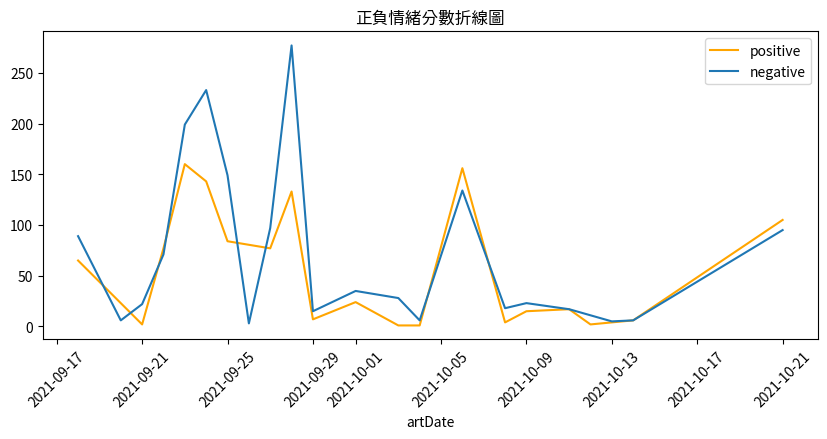

In [ ]:
#正負向情緒分數聲量折線圖
p = Ep_sentiment_count[Ep_sentiment_count['sentiments']=='positive']
n = Ep_sentiment_count[Ep_sentiment_count['sentiments']=='negative']

plt.figure(figsize=(10,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-09-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

##### 正負向情緒分數比例折線圖

In [ ]:
Ep_sentiment_count_r = Ep_sentiment_count.assign(ratio = Ep_sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

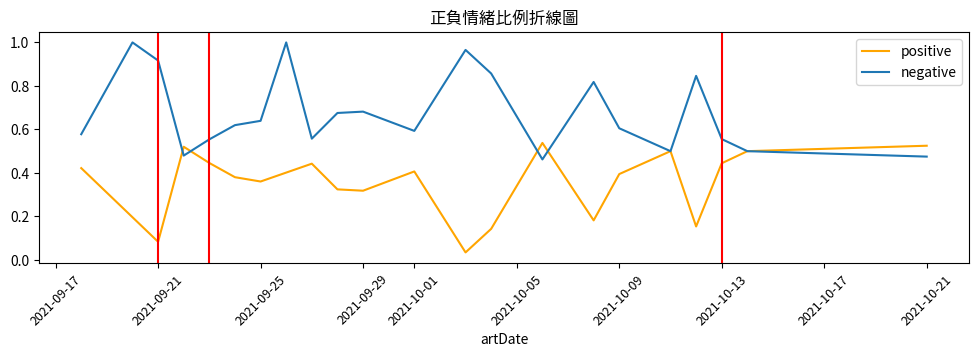

In [ ]:
Ep_sentiment_count_r = Ep_sentiment_count_r[Ep_sentiment_count_r['artDate'] > '2021/03/13']
p = Ep_sentiment_count_r[Ep_sentiment_count_r['sentiments']=='positive']
n = Ep_sentiment_count_r[Ep_sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(12,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
plt.axvline(x=datetime.strptime('2021-09-21', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-09-23', "%Y-%m-%d"), color="red", ls="-")
plt.axvline(x=datetime.strptime('2021-10-13', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

* 9/21-23 正負面情緒有稍微碰觸到
* 10/13之後的正面情緒稍微多一點
* 整體來說，負面情緒偏高

####3.3 文字雲
9/23 的文字雲

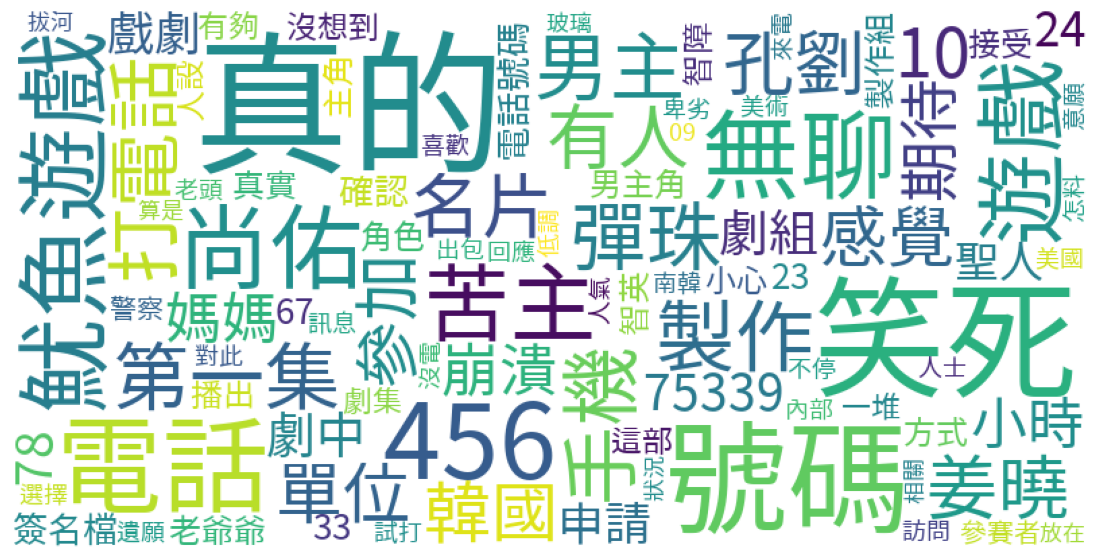

In [ ]:
dict_0923 = Wc_dict(Ep_word_count,"2021-09-23",450,1)

font = r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_0923)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

- 可以發現與第一集劇情內容、角色相關的字例如「打電話」、「號碼」「手機」、「456」、「男主」、「尚佑」居多
- 「75339」是之前徐乃麟唱的一首歌，與魷魚遊戲中出現的電話號碼一樣，都被網友打爆

## 4. 《魷魚遊戲》演員角色討論聲量比較

In [ ]:
character = ['孔劉','成奇勳','奇勳','政宰','李政宰','曹尚佑','尚佑','朴海秀','海秀','吳一男','一男','吳永秀','永秀','黃俊昊','俊昊','嘏雋','魏嘏雋','警察',
        '魏河俊','河俊','許成泰','成泰','張德秀','德秀','姜曉','鄭好娟','好娟','金姝怜','姝怜','韓美女','美女','阿里','阿里阿卜杜勒','智英',
        '李瑜美','瑜美','001','1號','一號','456號','218','218號','212','212號','101','101號','199號','199號','67','67號']

In [ ]:
#篩選出包含所有演員/角色代表字詞的word
character_count = word_all[word_all['word'].isin(character)]
character_count.head()

,word,size
29452,警察,372
10681,孔劉,338
3,001,277
11725,尚佑,226
10078,奇勳,195


In [ ]:
#篩選出包含所有演員/角色代表字詞的word
character_count2 = word_count[word_count['word'].isin(character)]
character_count2.head(10)

,artDate,word,size
16268,2021-09-25,吳一男,52
27440,2021-09-28,孔劉,50
90075,2021-10-17,成奇勳,50
22734,2021-09-27,孔劉,47
1212,2021-09-17,警察,40
1,2021-09-17,001,39
420,2021-09-17,奇勳,38
15398,2021-09-25,001,35
4912,2021-09-20,警察,33
497,2021-09-17,尚佑,32


##### 每日角色/演員討論聲量統計圖

In [ ]:
#同一個人會同時有多個代表字詞(EX:奇勳、政宰)，因此個別篩選出資料，建立該角色的Dataframe
c_cong = character_count2[character_count2.word.str.contains("孔劉")]
c_hoon = character_count2[character_count2.word.str.contains("奇勳|政宰|456")]
c_yu = character_count2[character_count2.word.str.contains("尚佑|海秀|218")]
c_nan = character_count2[character_count2.word.str.contains("一男|永秀|001|1號|一號")]
c_junho = character_count2[character_count2.word.str.contains("俊昊|河俊|嘏雋|警察")]
c_tai = character_count2[character_count2.word.str.contains("成泰|德秀|101")]
c_kang = character_count2[character_count2.word.str.contains("姜曉|好娟|67")]
c_mei = character_count2[character_count2.word.str.contains("美女|姝怜|212")]
c_ali = character_count2[character_count2.word.str.contains("阿里|199")]
c_ying = character_count2[character_count2.word.str.contains("智英|瑜美")]

In [ ]:
#定義change_index函數，將"word"欄位下所有值的轉為欄位，並依據日期將同一個人的所有代表字數量相加(命名為"size"欄位)
def change_index(df):
  two_level_index_series = df.set_index(["artDate","word"])["size"]
  new_df = two_level_index_series.unstack()
  new_df = new_df.rename_axis(columns=None)
  new_df = new_df.reset_index()
  new_df["size"] = new_df.sum(axis = 1, skipna = True, numeric_only=True)
  return new_df

In [ ]:
c_cong = change_index(c_cong)
c_hoon = change_index(c_hoon)
c_yu = change_index(c_yu)
c_nan = change_index(c_nan)
c_junho = change_index(c_junho)
c_tai = change_index(c_tai)
c_kang = change_index(c_kang)
c_mei = change_index(c_mei)
c_ali = change_index(c_ali)
c_ying = change_index(c_ying)

In [ ]:
#檢視轉換後的Dataframe，顯示每日該角色的總提及次數("size"欄位)
c_hoon.head()

,artDate,奇勳,成奇勳,李政宰,size
0,2021-09-17,38.0,NaN,16.0,54.0
1,2021-09-19,12.0,NaN,7.0,19.0
2,2021-09-20,5.0,NaN,NaN,5.0
3,2021-09-21,NaN,NaN,4.0,4.0
4,2021-09-22,NaN,NaN,20.0,20.0


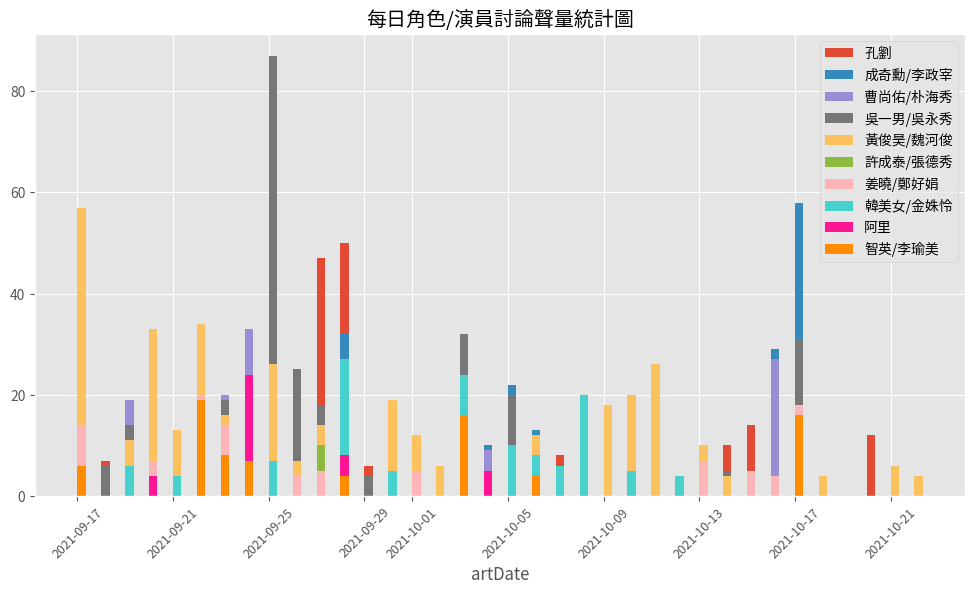

In [ ]:
plt.figure(figsize=(12,6))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('每日角色/演員討論聲量統計圖')
plt.xlabel('artDate')
plt.bar(c_cong['artDate'],c_cong['size'],align="edge",width=0.35,label="孔劉")
plt.bar(c_hoon['artDate'],c_hoon['size'],align="edge",width=0.35,label="成奇勳/李政宰")
plt.bar(c_yu['artDate'],c_yu['size'],align="edge",width=0.35,label="曹尚佑/朴海秀")
plt.bar(c_nan['artDate'],c_nan['size'],align="edge",width=0.35,label="吳一男/吳永秀")
plt.bar(c_junho['artDate'],c_junho['size'],align="edge",width=0.35,label="黃俊昊/魏河俊")
plt.bar(c_tai['artDate'],c_tai['size'],align="edge",width=0.35,label="許成泰/張德秀")
plt.bar(c_kang['artDate'],c_kang['size'],align="edge",width=0.35,label="姜曉/鄭好娟")
plt.bar(c_mei['artDate'],c_mei['size'],align="edge",width=0.35,label="韓美女/金姝怜",color='mediumturquoise')
plt.bar(c_ali['artDate'],c_ali['size'],align="edge",width=0.35,label="阿里",color='deeppink')
plt.bar(c_ying['artDate'],c_ying['size'],align="edge",width=0.35,label="智英/李瑜美",color='darkorange')
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

從上表可看出:
- 角色-黃俊昊(黃色)的討論聲量於9月17日剛上檔時，討論聲量為最高，推測是因為該角色於劇情支線中扮演了特殊的警察，並且演員的外貌出眾，也使得網友大量討論。
- 角色-吳一男(黑色)的討論聲量在9月25日特別高，推測應該與網友發現此角色的特殊身分有關，開始爆雷


##### 整個資料期間，角色/演員討論聲量總計圖

In [ ]:
#同一個人會同時有多個代表字詞(EX:奇勳、政宰)，因此個別篩選出資料
ac_cong = character_count[character_count.word.str.contains("孔劉")]
ac_hoon = character_count[character_count.word.str.contains("奇勳|政宰|456")]
ac_yu = character_count[character_count.word.str.contains("尚佑|海秀|218")]
ac_nan = character_count[character_count.word.str.contains("一男|永秀|001|1號|一號")]
ac_junho = character_count[character_count.word.str.contains("俊昊|河俊|嘏雋|警察")]
ac_tai = character_count[character_count.word.str.contains("成泰|德秀|101")]
ac_kang = character_count[character_count.word.str.contains("姜曉|好娟|67")]
ac_mei = character_count[character_count.word.str.contains("美女|姝怜|212")]
ac_ali = character_count[character_count.word.str.contains("阿里|199")]
ac_ying = character_count[character_count.word.str.contains("智英|瑜美")]

In [ ]:
ac_hoon.head()

,word,size
10078,奇勳,195
14380,成奇勳,150
18563,李政宰,133
328,456號,11
16750,政宰,2


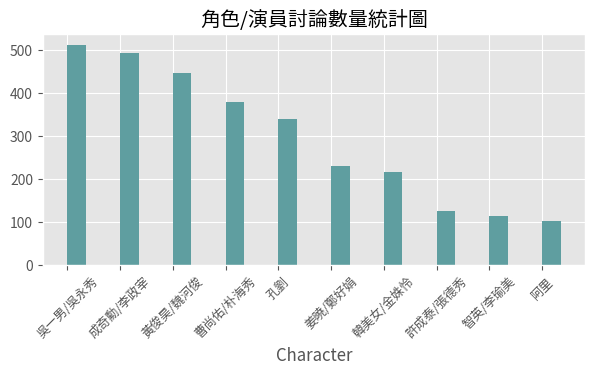

In [ ]:
plt.figure(figsize=(7,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('角色/演員討論數量統計圖')

plt.bar("吳一男/吳永秀",ac_nan['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("成奇勳/李政宰",ac_hoon['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("黃俊昊/魏河俊",ac_junho['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("曹尚佑/朴海秀",ac_yu['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("孔劉",ac_cong['size'],align="edge",width=0.35,color='cadetblue')
plt.bar("姜曉/鄭好娟",ac_kang['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("韓美女/金姝怜",ac_mei['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("許成泰/張德秀",ac_tai['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("智英/李瑜美",ac_ying['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("阿里",ac_ali['size'].sum(),align="edge",width=0.35,color='cadetblue')


plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('Character')
plt.show()

從整個資料期間來看:
- 角色-吳一男的討論聲量最高，推測是因為該角色對於劇情有極大影響，並且演員本身的精湛演技也被網友積極討論的緣故。
- 作為客串角色的孔劉雖然只有出現於第一集，但因本身人氣高且出演了具有代表性的場景(打畫片遊戲)，因此討論聲量也偏高。

## 5. 《魷魚遊戲》遊戲項目討論聲量比較

In [ ]:
#篩選出劇中五個遊戲項目的相關字詞
game_name = ['123木頭人','一二三木頭人','椪糖','踫糖','拔河','彈珠遊戲','打彈珠','玻璃橋','過墊腳石橋','墊腳石橋']

game_name_count = word_all[word_all['word'].isin(game_name)]
game_name_count.head()

,word,size
15516,拔河,280
18968,椪糖,165
22571,玻璃橋,121
86,123木頭人,118
644,一二三木頭人,76


In [ ]:
#篩選出劇中五個遊戲項目的相關字詞
game_name_count2 = word_count[word_count['word'].isin(game_name)]
game_name_count2.head()

,artDate,word,size
10963,2021-09-23,拔河,22
17135,2021-09-25,拔河,21
11218,2021-09-23,椪糖,20
56705,2021-10-05,拔河,19
6191,2021-09-21,拔河,17


##### 每日遊戲項目討論聲量統計圖

In [ ]:
#同個遊戲會同時有多個代表字詞(EX:123木頭人,一二三木頭人)，因此個別篩選出資料
g_wood = game_name_count2[game_name_count2.word.str.contains("123木頭人|一二三木頭人")]
g_cookie = game_name_count2[game_name_count2.word.str.contains("椪糖")]
g_tug_of_war = game_name_count2[game_name_count2.word.str.contains("拔河")]
g_ball = game_name_count2[game_name_count2.word.str.contains("彈珠遊戲|打彈珠")]
g_bridge = game_name_count2[game_name_count2.word.str.contains("玻璃橋|過墊腳石橋|墊腳石橋")]

In [ ]:
g_wood = change_index(g_wood)
g_cookie = change_index(g_cookie)
g_tug_of_war = change_index(g_tug_of_war)
g_ball = change_index(g_ball)
g_bridge = change_index(g_bridge)

In [ ]:
g_wood.head()

,artDate,123木頭人,一二三木頭人,size
0,2021-09-20,NaN,4.0,4.0
1,2021-09-22,4.0,NaN,4.0
2,2021-09-23,7.0,4.0,11.0
3,2021-09-24,4.0,NaN,4.0
4,2021-09-25,6.0,5.0,11.0


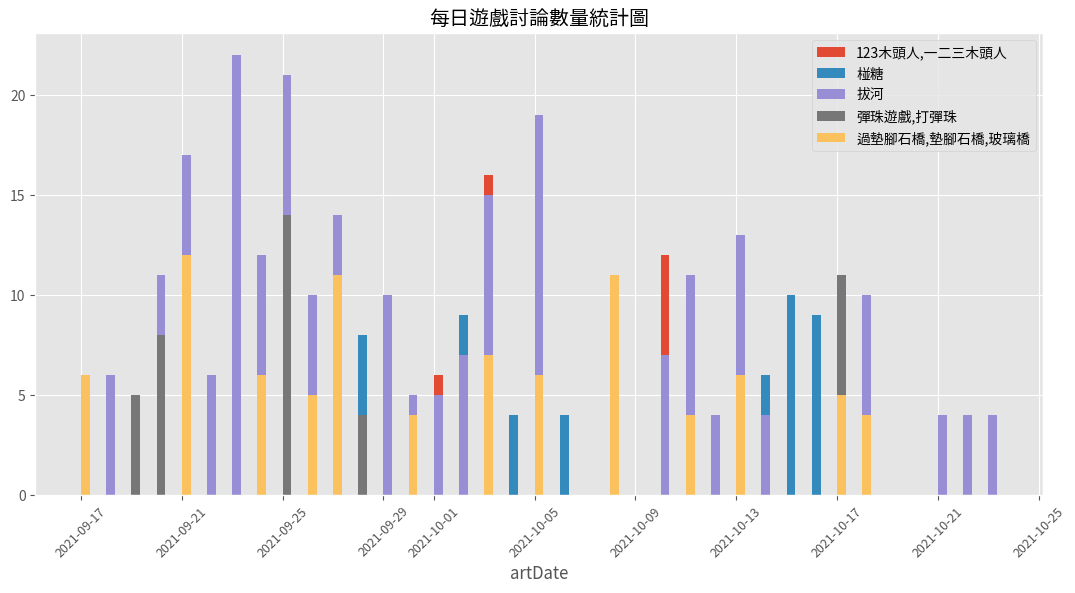

In [ ]:
plt.figure(figsize=(13,6))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('每日遊戲討論數量統計圖')
plt.xlabel('artDate')
plt.bar(g_wood['artDate'],g_wood['size'],align="edge",width=0.35,label="123木頭人,一二三木頭人")
plt.bar(g_cookie['artDate'],g_cookie['size'],align="edge",width=0.35,label="椪糖")
plt.bar(g_tug_of_war['artDate'],g_tug_of_war['size'],align="edge",width=0.35,label="拔河")
plt.bar(g_ball['artDate'],g_ball['size'],align="edge",width=0.35,label="彈珠遊戲,打彈珠")
plt.bar(g_bridge['artDate'],g_bridge['size'],align="edge",width=0.35,label="過墊腳石橋,墊腳石橋,玻璃橋")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

從統計圖可以發現：
*   拔河跟玻璃橋幾乎每天都有討論度
*   推測原因為探討拔河不是只需要力氣大，戰術也是很重要
*   如何度過玻璃橋，也是網友持續討論的議題





##### 整個資料期間，遊戲項目討論聲量總計圖

In [ ]:
#同一個遊戲會同時有多個代表字詞(EX:123木頭人,一二三木頭人)，因此個別篩選出資料
sg_wood = game_name_count[game_name_count.word.str.contains("123木頭人|一二三木頭人")]
sg_cookie = game_name_count[game_name_count.word.str.contains("椪糖")]
sg_tug_of_war = game_name_count[game_name_count.word.str.contains("拔河")]
sg_ball = game_name_count[game_name_count.word.str.contains("彈珠遊戲|打彈珠")]
sg_bridge = game_name_count[game_name_count.word.str.contains("玻璃橋|過墊腳石橋|墊腳石橋")]

In [ ]:
sg_wood

,word,size
86,123木頭人,118
644,一二三木頭人,76


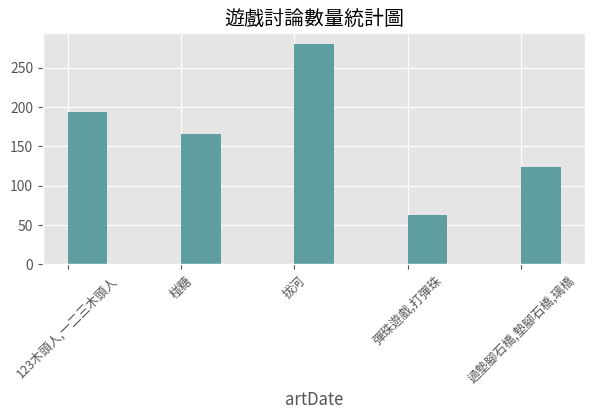

In [ ]:
plt.figure(figsize=(7,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.title('遊戲討論數量統計圖')
plt.xlabel('artDate')

plt.bar("123木頭人,一二三木頭人",sg_wood['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("椪糖",sg_cookie['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("拔河",sg_tug_of_war['size'].sum(),align="edge",width=0.35,color='cadetblue')
plt.bar("彈珠遊戲,打彈珠",sg_ball['size'],align="edge",width=0.35,color='cadetblue')
plt.bar("過墊腳石橋,墊腳石橋,璃橋",sg_bridge['size'].sum(),align="edge",width=0.35,color='cadetblue')


plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artDate')
plt.show()

從統計圖可以發現：
*   拔河的討論聲量最高，推測可能是主角的隊伍本來不被看好會獲勝，但聽從了001號吳一男的經驗，最後拿下了勝利
*   123木頭人也是整體討論度較高的遊戲之一，推測原因為整個影集的第一個遊戲，除了遊戲玩法讓大家嚇一大跳之外，也是台灣人較為熟悉的遊戲！

